### Name: Yulin Zhuo 
### Github username: edsml-yz6622

This jupyter notebook shows one example of the usage of predictLSTM.py. For those who want to use the model to predict SWE, they can follow the steps shown below.

# Import

In [1]:
import sys
sys.path.append("./swe_tool")

import torch
import pandas as pd
import numpy as np
from swe_tool.predictLSTM import predictLSTM
from swe_tool import tool
from swe_tool.sweDataset import sweDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define varibales and useful functions

In [2]:
folder_path = './dataset/'

In [3]:
# Define variables
train_file_path = folder_path + 'train_updated_sc.csv'
test_file_path = folder_path + 'test_updated_sc.csv'
var = ['HS']
var_3 = ['HS','precipitation','temperature']
ts = 30

# read data
df = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

In [4]:
def predict(df_train, df_test, model, var_list, ts):
    """
    Evaluate a given model on the test data.

    :param df_train: Training dataframe.
    :type df_train: pd.DataFrame
    :param df_test: Test dataframe.
    :type df_test: pd.DataFrame
    :param model: A trained model for evaluation.
    :type model: torch.nn.Module
    :param var_list: List of variables (column names) used in predicting.
    :type var_list: list
    :param ts: Time sequence length for prediction.
    :type ts: int

    :return: results of the evaluation which includes metrics and predicted values,
             tuple of (rmse_test, mae_test, mbe_test, r2_test, kge_test, y_test_ori, test_pred).
    :rtype: tuple
    """
    # Pre-process data
    dataset = sweDataset(df=df_train, df_test=df_test, var=var_list, ts=ts)
    
    # Create data loader for evaluating the model
    _, _, test_loader = dataset.get_data_loaders()
    
    # Evaluate the model
    results = tool.evaluate_model(test_loader, model, dataset)
    
    return results

In [5]:
def compute_overall_perf(results):
    """
    Compute and display overall performance metrics for the given predictions.

    :param results: results of the evaluation which includes metrics and predicted values,
                    tuple of (rmse_test, mae_test, mbe_test, r2_test, kge_test, y_test_ori, test_pred).
    :type results: list of tuples
    """
    true_test = np.concatenate([r[5] for r in results])
    pred_test = np.concatenate([r[6] for r in results])

    # Compute the overall models performance metrics
    rmse_test = np.sqrt(mean_squared_error(true_test, pred_test))
    kge_test = tool.kge(true_test.reshape(-1), pred_test.reshape(-1))
    mae_test = mean_absolute_error(true_test, pred_test)
    r2_test = r2_score(true_test, pred_test)
    mbe_test = tool.mean_bias_error(true_test, pred_test) 

    print('Overall Root Mean Squared Error on Test Data:', rmse_test)
    print('Overall Mean Bias Error on Test Data:', mbe_test)
    print('Overall Mean Absolute Error on Test Data:', mae_test)
    print('Kling-Gupta efficiency on Test Data:', kge_test)
    print('R2 Score on Test Data:', r2_test)

    # Plot the overall prediction errors
    tool.plot_scatter(true_test, pred_test)

# Multi-model system

## Multiple models based on snow classes

#### Optional: Ensemble models and save MLSTM

After finishing training individual models on each snow class, we can save the muti-LSTM models into a single model.

In [6]:
# Create ensemble models instance
MLSTM_sc = predictLSTM("./models/model_sc_2.pth",type='snowclass',sub_type=2)

In [7]:
# Add models for different snow class
for snow_class in [1, 2, 3, 5, 6]:
    model_path = f'./models/model_sc_{snow_class}.pth' 
    MLSTM_sc.add_snowclass_model(snow_class, model_path)

In [7]:
# Save the model
torch.save(MLSTM_sc, './models/MLSTM_sc.pth')

#### Data Preprocess

In [8]:
# Define dataframe for each snow class
df_1 = df[df['snow_class'] == 1].copy()
df_1_test = df_test[df_test['snow_class'] == 1].copy()

df_2 = df[df['snow_class'] == 2].copy()
df_2_test = df_test[df_test['snow_class'] == 2].copy()

df_3 = df[df['snow_class'] == 3].copy()
df_3_test = df_test[df_test['snow_class'] == 3].copy()

df_5 = df[df['snow_class'] == 5].copy()
df_5_test = df_test[df_test['snow_class'] == 5].copy()

df_6 = df[df['snow_class'] == 6].copy()
df_6_test = df_test[df_test['snow_class'] == 6].copy()


#### Predict SWE and evaluate models

In [9]:
# Load the MLSTM saved before
MLSTM_sc = torch.load("./models/MLSTM_sc.pth")

In [10]:
# Define variables
df_train = [df_1, df_2, df_3, df_5, df_6]
df_test = [df_1_test, df_2_test, df_3_test, df_5_test, df_6_test]
var_list = [var, var, var_3, var, var]
ts = [14, 10, 30, 10, 30]
models = [MLSTM_sc.snowclass_models[i] for i in [1, 2, 3, 5, 6]]


Root Mean Squared Error on Test Data: 5.417531
Mean Bias Error on Test Data: 1.4441174
Mean Absolute Error on Test Data: 3.5839632
Kling-Gupta efficiency on Test Data: 0.9296672896933307
R2 Score on Test Data: 0.9417831750328711


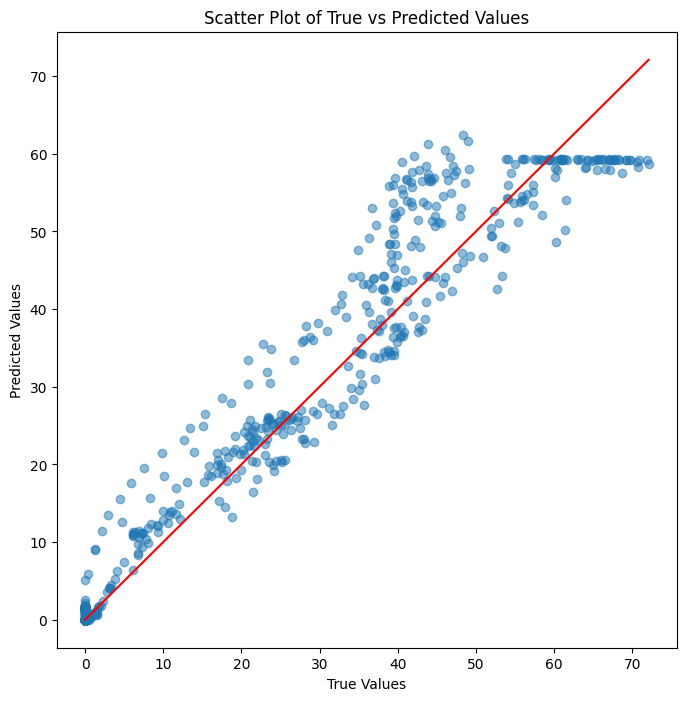

Root Mean Squared Error on Test Data: 2.296368
Mean Bias Error on Test Data: -0.78232497
Mean Absolute Error on Test Data: 1.3056171
Kling-Gupta efficiency on Test Data: 0.7792183160336044
R2 Score on Test Data: 0.8999030651521186


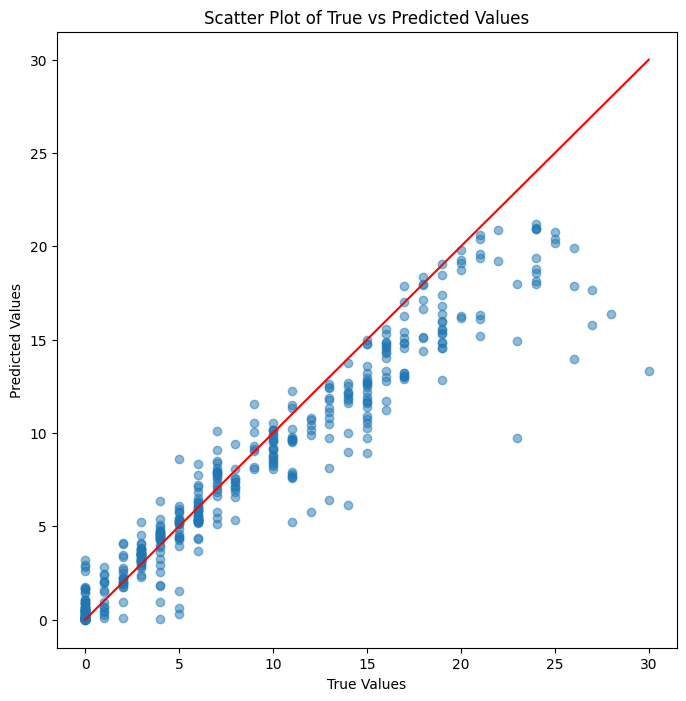

Root Mean Squared Error on Test Data: 8.843374
Mean Bias Error on Test Data: -0.96192634
Mean Absolute Error on Test Data: 5.5037155
Kling-Gupta efficiency on Test Data: 0.9517735100253704
R2 Score on Test Data: 0.9653423218422081


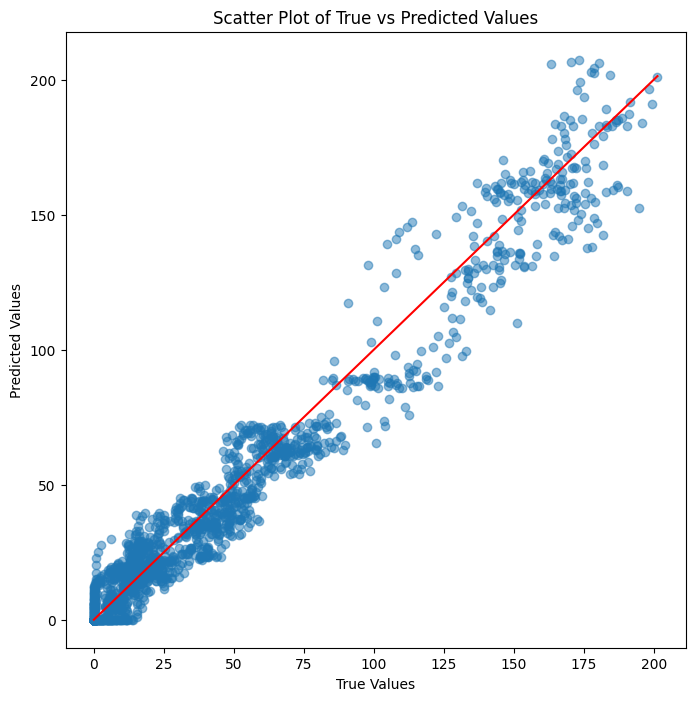

Root Mean Squared Error on Test Data: 1.2354113
Mean Bias Error on Test Data: 0.38732824
Mean Absolute Error on Test Data: 0.7373505
Kling-Gupta efficiency on Test Data: 0.9204231972774873
R2 Score on Test Data: 0.971144726403423


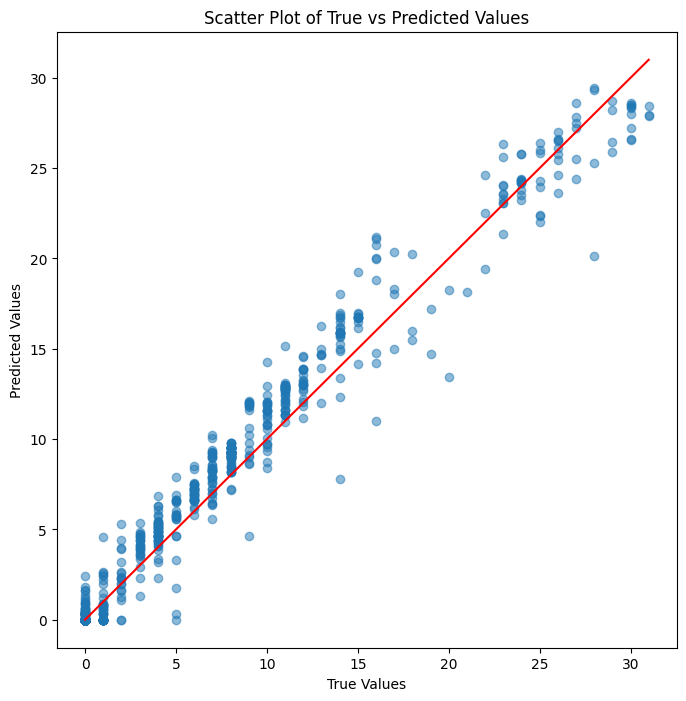

Root Mean Squared Error on Test Data: 5.269494
Mean Bias Error on Test Data: 1.1103039
Mean Absolute Error on Test Data: 3.7002194
Kling-Gupta efficiency on Test Data: 0.958895237927189
R2 Score on Test Data: 0.9769202394010909


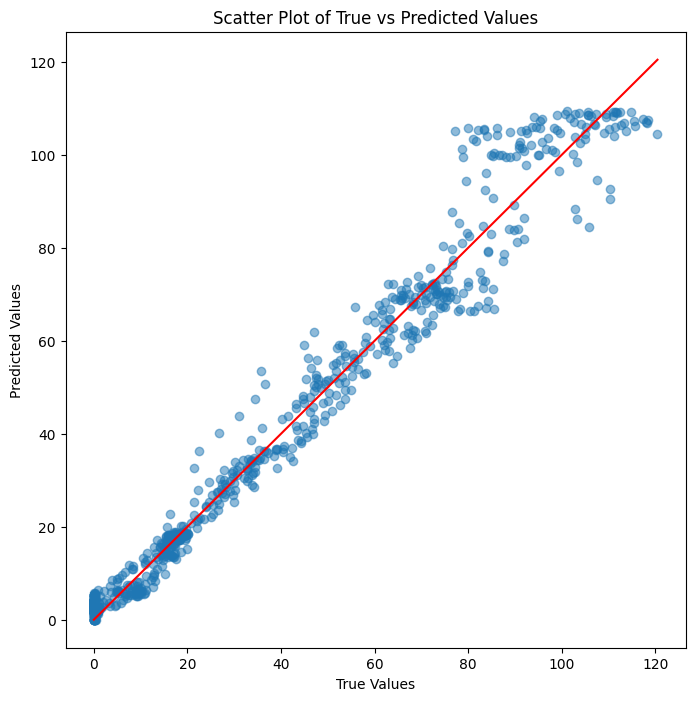

In [11]:
# Processing and evaluating for each snowclass
results_sc = []
for i in range(5):
    result = predict(df_train[i], df_test[i], models[i], var_list[i], ts[i])
    results_sc.append(result)

In [12]:
# Calculate the average RMSE, MAE, MBE over five models
rmse_avg_model = sum(res[0] for res in results_sc)/5
mae_avg_model = sum(res[1] for res in results_sc)/5
mbe_avg_model = sum(res[2] for res in results_sc)/5

print(f"RMSE of averaging all models: {rmse_avg_model}")
print(f"MAE of averaging all models: {mae_avg_model}")
print(f"MBE of averaging all models: {mbe_avg_model}")

RMSE of averaging all models: 4.612435698509216
MAE of averaging all models: 2.9661731362342834
MBE of averaging all models: 0.23949964642524718


Overall Root Mean Squared Error on Test Data: 6.5053315
Overall Mean Bias Error on Test Data: -0.047675833
Overall Mean Absolute Error on Test Data: 3.6719844
Kling-Gupta efficiency on Test Data: 0.9678698441034608
R2 Score on Test Data: 0.9693189583003672


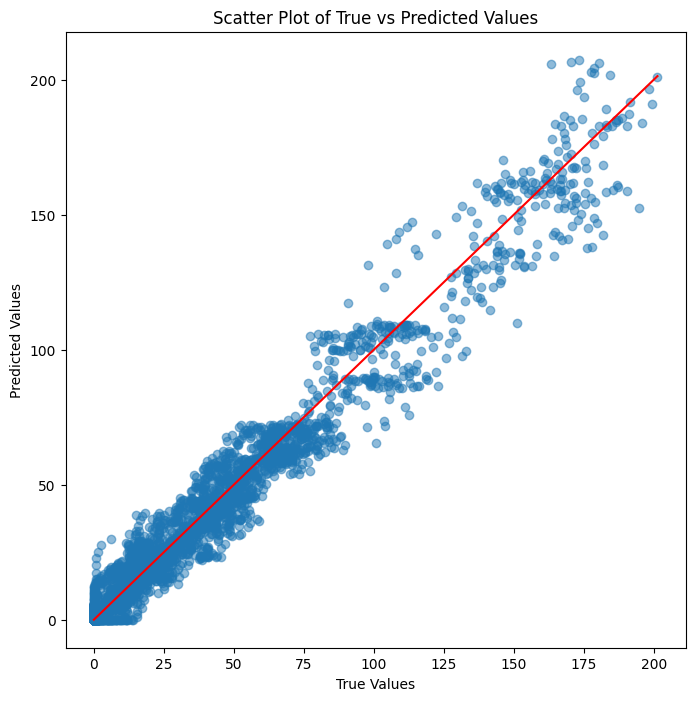

In [13]:
# Concate all the predictions and evaluate the overall performance
compute_overall_perf(results_sc)

## Optional: Multiple models based on countries

#### Optional: Ensemble models and save MLSTM

In [14]:
# Create ensemble models instance
MLSTM_countries = predictLSTM("./models/model_canada.pth")

In [15]:
# Add models for different counties
for country in ['canada', 'switzerland', 'norway', 'US']:
    model_path = f'./models/model_{country}.pth'
    MLSTM_countries.add_country_model(country, model_path)

In [25]:
# Save the model
torch.save(MLSTM_countries, './models/MLSTM_countries.pth')

#### Data Pre-process

In [16]:
# read data
df = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Split the dataset based on different country
df_norway = df[df['loc'].str.startswith('norway')].copy()
norway_df_test = df_test[df_test['loc'].str.startswith('norway')].copy()

df_canada = df[df['loc'].str.startswith('canada')].copy()
canada_df_test = df_test[df_test['loc'].str.startswith('canada')].copy()

df_swi = df[(df['loc'].str.startswith('gps')) | (df['loc']=='wfj')].copy()
swi_df_test = df[df['loc']=='klo'].copy()

df_us = df[(df['loc'].str.startswith('US'))].copy()
us_df_test = df_test[df_test['loc'].str.startswith('US')].copy()

#### Predict SWE and evaluate models

In [17]:
# Load the MLSTM saved before
MLSTM_countries = torch.load("./models/MLSTM_countries.pth")

In [49]:
# Define variables
var_nor = ['HS', 'precipitation']
df_train = [df_norway, df_canada, df_swi, df_us]
df_test = [norway_df_test, canada_df_test, swi_df_test, us_df_test]
var_list = [var_nor, var, var, var, var]
ts = [30, 30, 30, 30]
models = [MLSTM_countries.country_models[i] for i in ['norway','canada','switzerland','US']]

Root Mean Squared Error on Test Data: 6.2265663
Mean Bias Error on Test Data: -2.6994042
Mean Absolute Error on Test Data: 3.4373248
Kling-Gupta efficiency on Test Data: 0.6986508283805068
R2 Score on Test Data: 0.8742092599845332


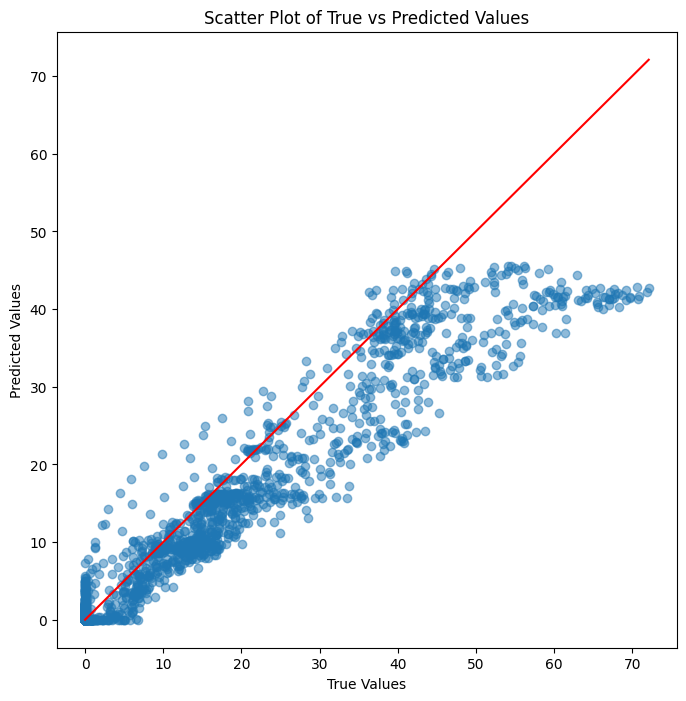

Root Mean Squared Error on Test Data: 8.81022
Mean Bias Error on Test Data: 1.2618157
Mean Absolute Error on Test Data: 6.1625834
Kling-Gupta efficiency on Test Data: 0.9552967853508467
R2 Score on Test Data: 0.9713512684757469


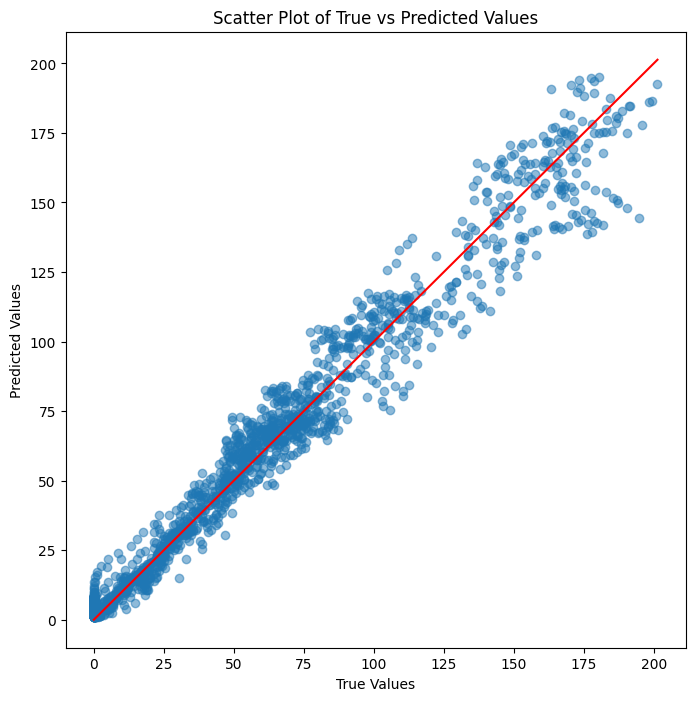

Root Mean Squared Error on Test Data: 4.1150494
Mean Bias Error on Test Data: 2.041185
Mean Absolute Error on Test Data: 2.8144515
Kling-Gupta efficiency on Test Data: 0.7938334826238247
R2 Score on Test Data: 0.8933146034673959


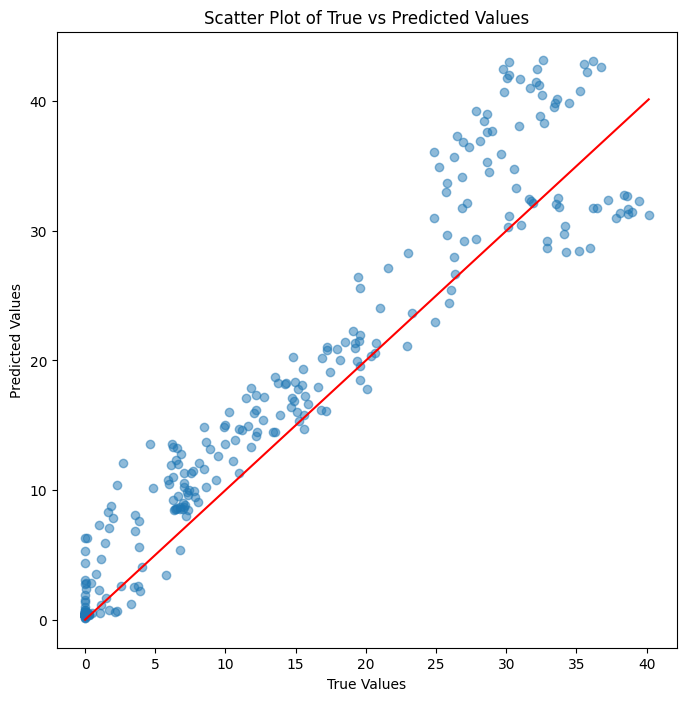

Root Mean Squared Error on Test Data: 1.5232742
Mean Bias Error on Test Data: -0.092363715
Mean Absolute Error on Test Data: 0.8415793
Kling-Gupta efficiency on Test Data: 0.9144157176353772
R2 Score on Test Data: 0.9552770317390525


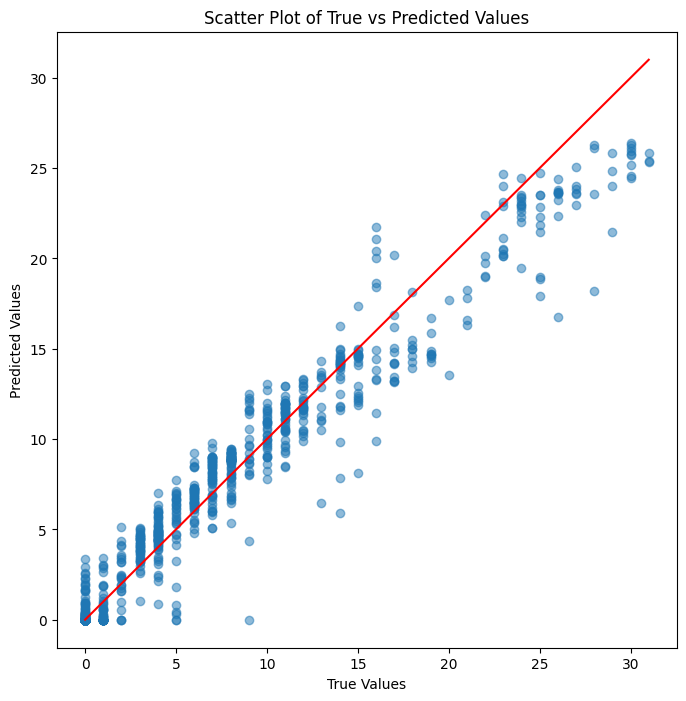

In [19]:
# Processing and evaluating for each country
results_countries = []
for i in range(4):
    result = predict(df_train[i], df_test[i], models[i], var_list[i], ts[i])
    results_countries.append(result)

In [20]:
# Calculate the average RMSE, MAE, MBE over five models
rmse_avg_model = sum(res[0] for res in results_countries)/5
mae_avg_model = sum(res[1] for res in results_countries)/5
mbe_avg_model = sum(res[2] for res in results_countries)/5

print(f"RMSE of averaging all models: {rmse_avg_model}")
print(f"MAE of averaging all models: {mae_avg_model}")
print(f"MBE of averaging all models: {mbe_avg_model}")

RMSE of averaging all models: 4.135021924972534
MAE of averaging all models: 2.651187777519226
MBE of averaging all models: 0.10224652290344238


Overall Root Mean Squared Error on Test Data: 6.4338245
Overall Mean Bias Error on Test Data: -0.5669147
Overall Mean Absolute Error on Test Data: 3.671813
Kling-Gupta efficiency on Test Data: 0.96340566210275
R2 Score on Test Data: 0.9697517699158859


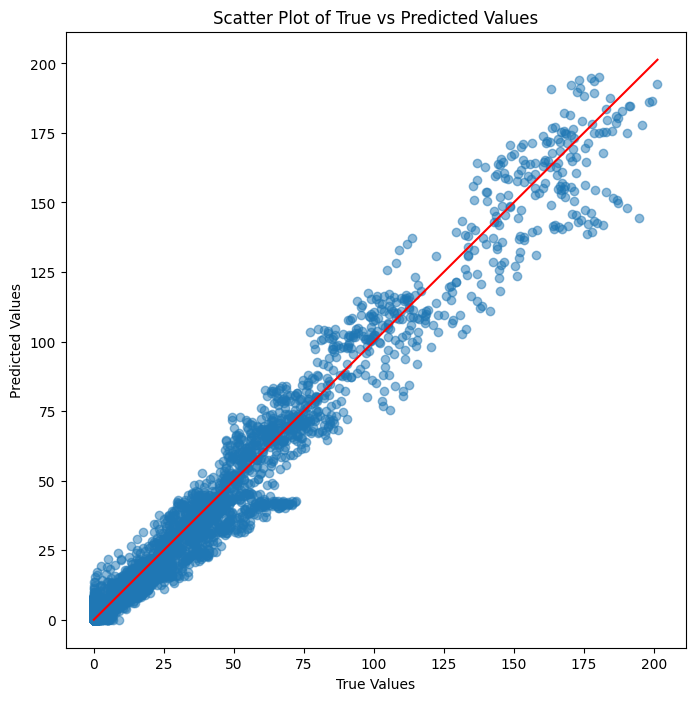

In [21]:
# Concate all the predictions and evaluate the overall performance
compute_overall_perf(results_countries)

# Single global model

#### Predict SWE and evaluate models

In [22]:
# Create ensemble models
SLSTM = predictLSTM("./models/global_model.pth",type='general')

In [23]:
# Define variables
df_train = [df, df, df, df, df]
df_test = [df_1_test, df_2_test, df_3_test, df_5_test, df_6_test]
var_list = [var, var, var, var, var]
ts = [30, 30, 30, 30, 30]
models = [SLSTM.model for i in [1, 2, 3, 5, 6]]


Root Mean Squared Error on Test Data: 6.4124265
Mean Bias Error on Test Data: -1.8965117
Mean Absolute Error on Test Data: 4.3030996
Kling-Gupta efficiency on Test Data: 0.8212041277985689
R2 Score on Test Data: 0.9183158270551874


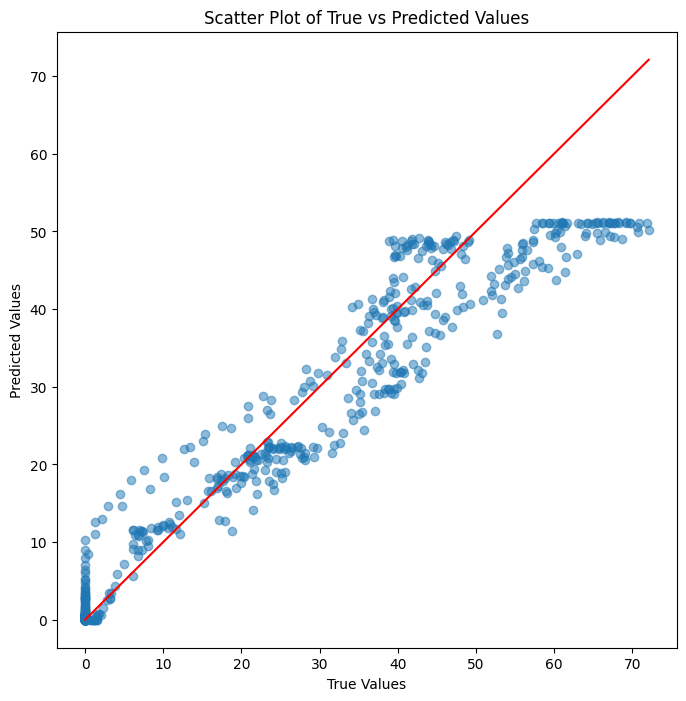

Root Mean Squared Error on Test Data: 1.6802071
Mean Bias Error on Test Data: -0.6114423
Mean Absolute Error on Test Data: 1.0064771
Kling-Gupta efficiency on Test Data: 0.8124065788045747
R2 Score on Test Data: 0.9322594998003463


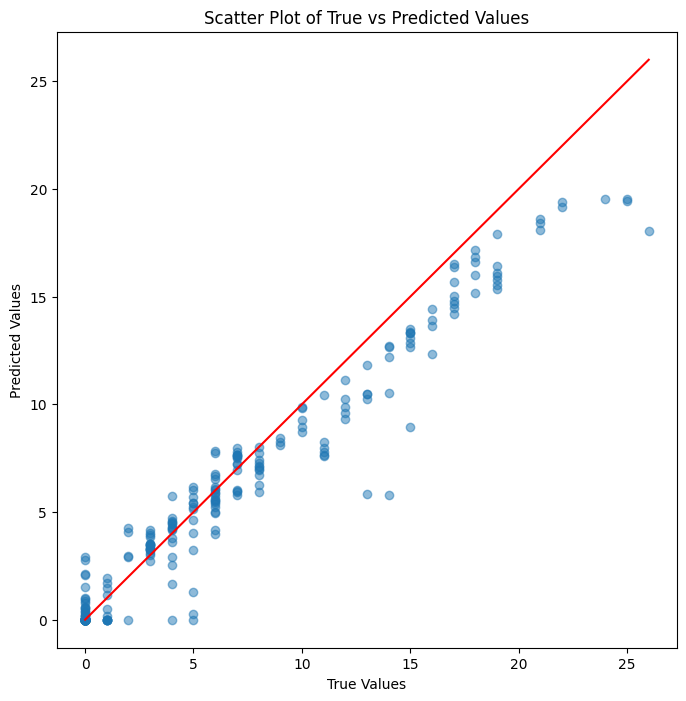

Root Mean Squared Error on Test Data: 8.562099
Mean Bias Error on Test Data: -3.3791528
Mean Absolute Error on Test Data: 5.2116914
Kling-Gupta efficiency on Test Data: 0.8977612477509219
R2 Score on Test Data: 0.9690838716591186


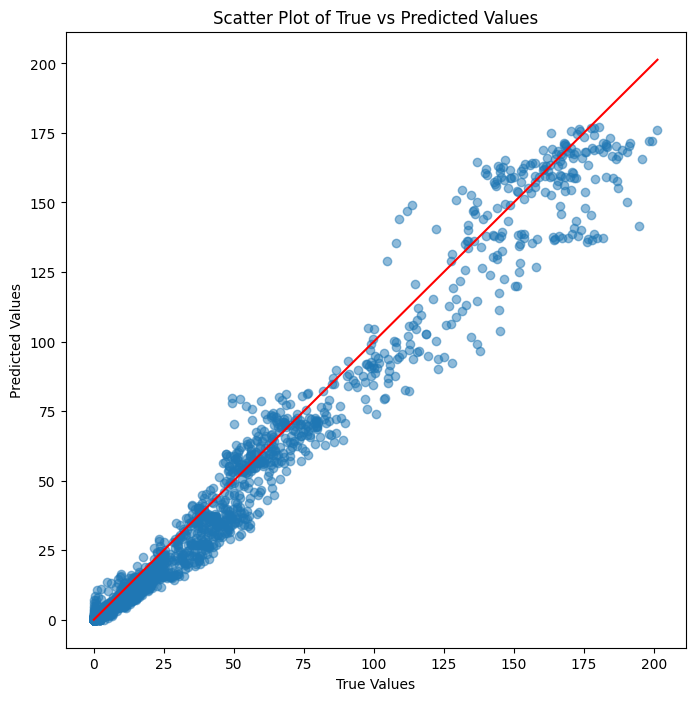

Root Mean Squared Error on Test Data: 1.176398
Mean Bias Error on Test Data: -0.0980145
Mean Absolute Error on Test Data: 0.5483437
Kling-Gupta efficiency on Test Data: 0.9510163058276726
R2 Score on Test Data: 0.9747338507804232


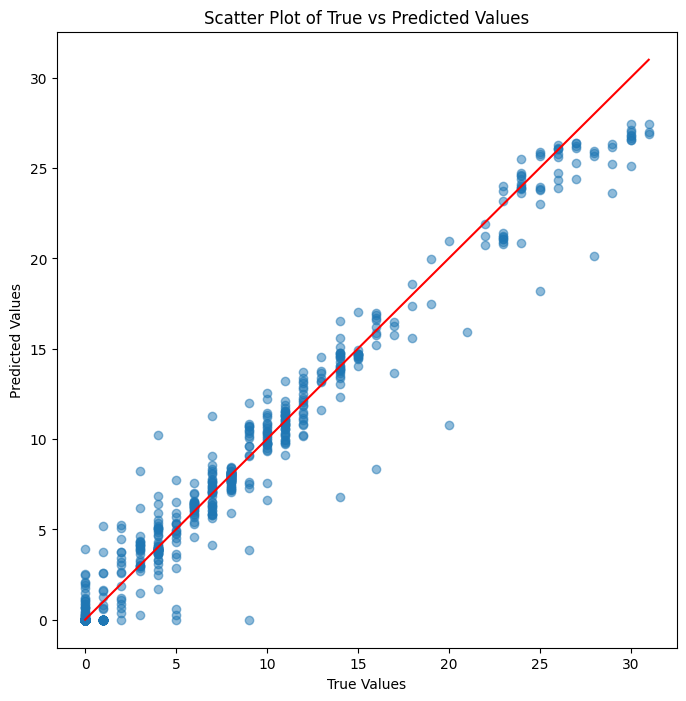

Root Mean Squared Error on Test Data: 7.114582
Mean Bias Error on Test Data: -1.6822733
Mean Absolute Error on Test Data: 4.5521073
Kling-Gupta efficiency on Test Data: 0.863846323122884
R2 Score on Test Data: 0.9579280913558244


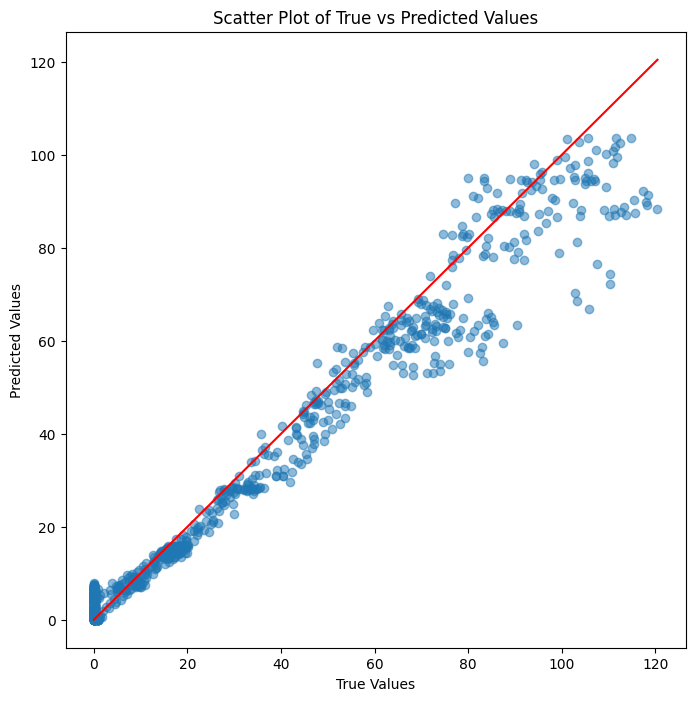

In [24]:
# Processing and evaluating for each snowclass
results_slstm = []
for i in range(5):
    result = predict(df_train[i], df_test[i], models[i], var_list[i], ts[i])
    results_slstm.append(result)

In [25]:
# Calculate the average RMSE, MAE, MBE over five models
rmse_avg_model = sum(res[0] for res in results_slstm)/5
mae_avg_model = sum(res[1] for res in results_slstm)/5
mbe_avg_model = sum(res[2] for res in results_slstm)/5

print(f"RMSE of averaging all models: {rmse_avg_model}")
print(f"MAE of averaging all models: {mae_avg_model}")
print(f"MBE of averaging all models: {mbe_avg_model}")

RMSE of averaging all models: 4.989142632484436
MAE of averaging all models: 3.1243438363075255
MBE of averaging all models: -1.5334789097309112


Overall Root Mean Squared Error on Test Data: 6.83766
Overall Mean Bias Error on Test Data: -2.0607755
Overall Mean Absolute Error on Test Data: 3.8169863
Kling-Gupta efficiency on Test Data: 0.8952375926478292
R2 Score on Test Data: 0.9685288237496632


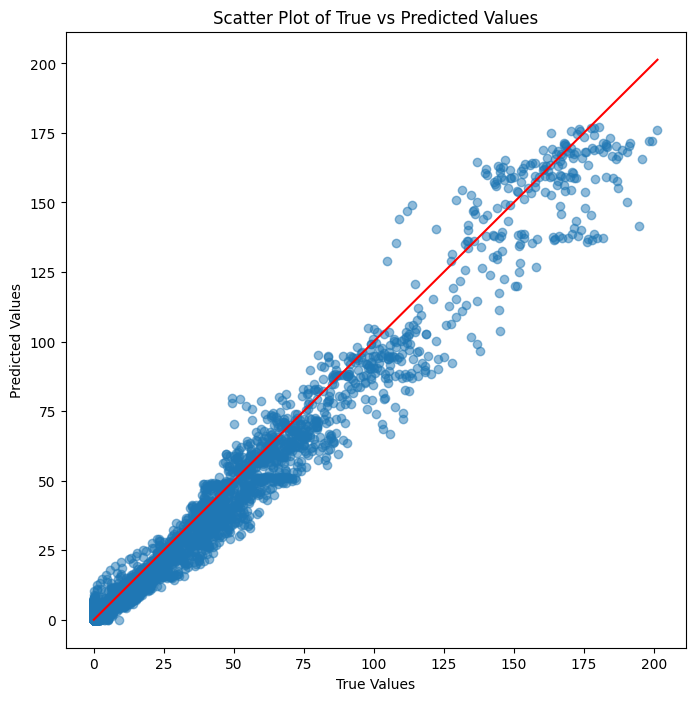

In [26]:
# Concate all the predictions and evaluate performance
compute_overall_perf(results_slstm)

# Plot time series to compare SLSTM and MLSTM

Plot the time series of station - norway_121420 and compare the result from MLSTM and SLSTM.

In [27]:
# Read data
df = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

df_canada_4B16P= df_test[df_test['loc'] == 'canada_4B16P'].copy()
df_canada_4B16P = df_canada_4B16P.sort_values(by="date")
df_canada_4B16P.reset_index(drop=True, inplace=True)
df_canada_4B16P = df_canada_4B16P[(pd.to_datetime(df_canada_4B16P['date']).dt.year >= 2011) & (pd.to_datetime(df_canada_4B16P['date']).dt.year <= 2014)]
df_canada_4B16P

,date,HS,station_SWE,loc,precipitation,snowfall,solar_radiation,temperature,rain,snow_class
365,2012-10-02,23.391304,1.125098,canada_4B16P,4.330184e-04,1.862645e-09,113285.994911,5.280487,0.003455,6
366,2012-10-03,25.368421,1.182114,canada_4B16P,5.587935e-09,1.862645e-09,625315.971911,0.949982,0.003049,6
367,2012-10-04,26.684211,1.284444,canada_4B16P,5.587935e-09,1.862645e-09,585236.973711,1.139801,0.003049,6
368,2012-10-05,20.125000,1.248588,canada_4B16P,5.587935e-09,1.862645e-09,425738.980876,2.015045,0.003049,6
369,2012-10-06,19.400000,1.281298,canada_4B16P,1.275912e-06,1.862645e-09,515711.976834,3.298279,0.003050,6
...,...,...,...,...,...,...,...,...,...,...
725,2013-09-27,22.500000,0.092963,canada_4B16P,1.142954e-03,5.699694e-07,769271.965445,1.989929,0.004120,6
726,2013-09-28,23.500000,0.087165,canada_4B16P,6.347438e-03,2.006780e-03,136705.993859,1.470581,0.007119,6
727,2013-09-29,12.666667,0.096673,canada_4B16P,2.294329e-02,1.750812e-02,35626.998400,0.270691,0.008145,6
728,2013-09-30,14.705882,0.047115,canada_4B16P,3.222997e-02,3.167673e-02,64210.997116,-0.325806,0.003568,6


Root Mean Squared Error on Test Data: 4.4527855
Mean Bias Error on Test Data: -0.16969605
Mean Absolute Error on Test Data: 3.4473464
Kling-Gupta efficiency on Test Data: 0.9122384459721984
R2 Score on Test Data: 0.9764333625874757


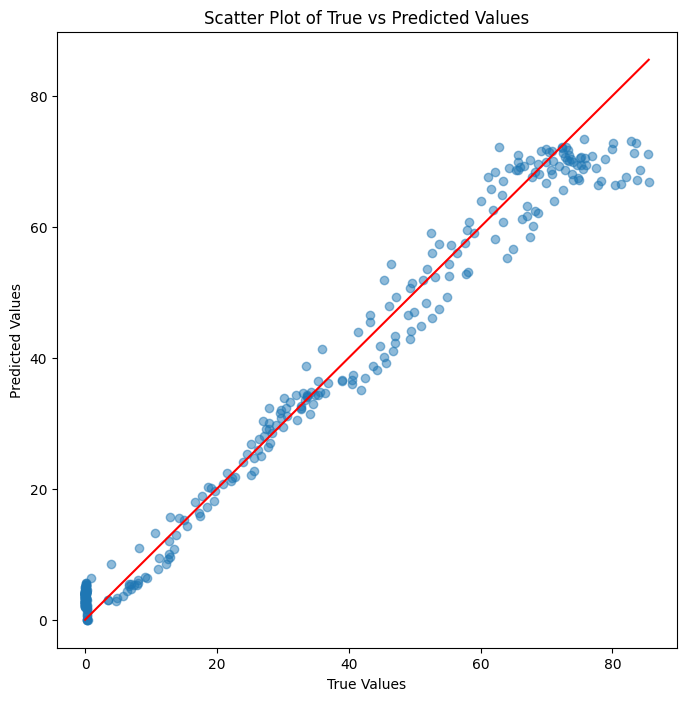

In [28]:
# Get the prediction from MLSTM
dataset_canada_4B16P = sweDataset(df=df_6, df_test=df_canada_4B16P, var=var, ts=30)
_,_,test_loader_can = dataset_canada_4B16P.get_data_loaders()
results_mlstm = tool.evaluate_model(test_loader_can, MLSTM_sc.snowclass_models[6], dataset_canada_4B16P)

Root Mean Squared Error on Test Data: 7.510862
Mean Bias Error on Test Data: -2.1243908
Mean Absolute Error on Test Data: 5.7509627
Kling-Gupta efficiency on Test Data: 0.7904187993694229
R2 Score on Test Data: 0.9329477092656051


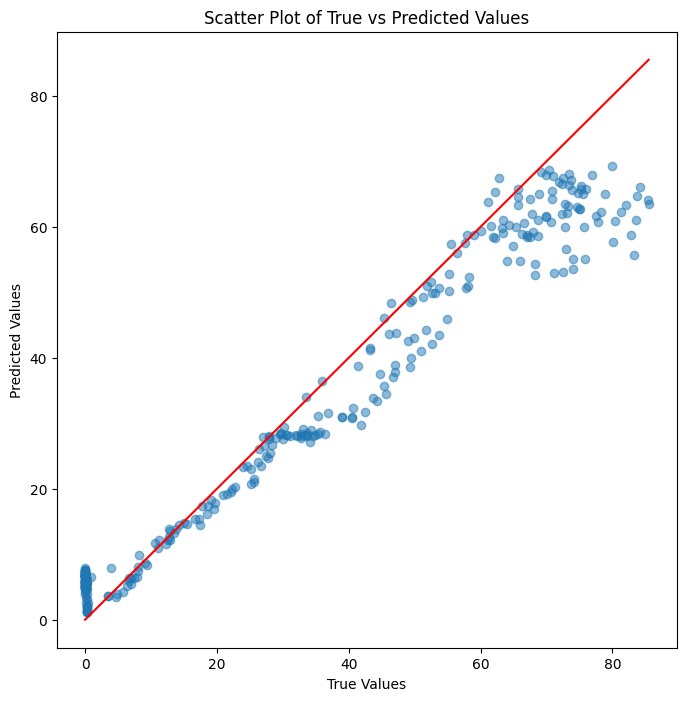

In [29]:
# Get the prediction from SLSTM
dataset_canada_4B16P = sweDataset(df=df, df_test=df_canada_4B16P, var=var, ts=30)
_,_,test_loader_can = dataset_canada_4B16P.get_data_loaders()
results_slstm = tool.evaluate_model(test_loader_can, SLSTM.model, dataset_canada_4B16P)

In [30]:
dates = df_canada_4B16P['date']

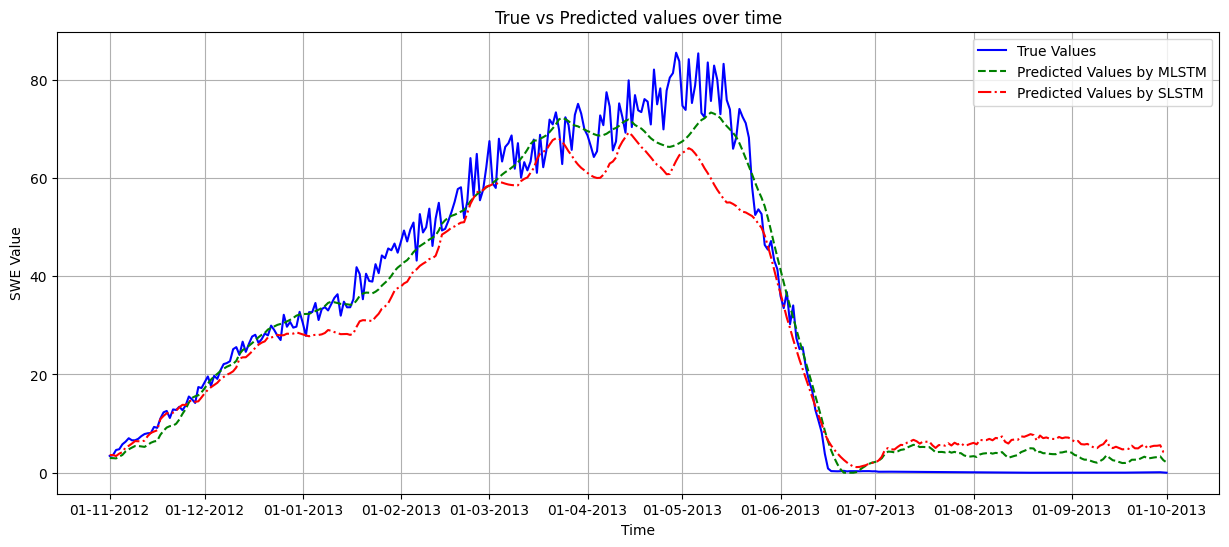

In [31]:
tool.plot_time_series(results_mlstm[5][-len(results_slstm[6]):], results_mlstm[6][-len(results_slstm[6]):], results_slstm[6], dates[-len(results_slstm[6]):])

# Optional: Ensemble Training by averaging the results from multi-models system

This method tried to ensemble all the snow class models, and take average over all the predictions from different models to get the final output. But the performance does not look great.

In [32]:
def average_prediction(ensemble_models, df=df, df_test=df_test):
    """
    Compute the average prediction of ensemble models on test data.

    :param ensemble_models: A dictionary where stored the trained models.
    :type ensemble_models: dict
    :param df: Training dataframe with columns required for modeling, default is 'df'.
    :type df: pd.DataFrame, optional
    :param df_test: Test dataframe with columns required for modeling, default is 'df_test'.
    :type df_test: pd.DataFrame, optional

    :return: tuple of (y_true, avg_prediction).y_true - the observed valued, 
             avg_prediction - averaged predictions
    :rtype: tuple(np.array, np.array)
    """
    total_predictions = []

    # Get the predictions for all models
    for i in [1,2,3,5,6]:
        if i != 3 :
            dataset=sweDataset(df=df, df_test=df_test, var=['HS'], ts=30)
        else:
            dataset=sweDataset(df=df, df_test=df_test, var=['HS','temperature','precipitation'], ts=30)
            
        _,_,test_loader = dataset.get_data_loaders()
        _, _, _, _, _, y_true, prediction = tool.evaluate_model(test_loader, ensemble_models[i], dataset)
        total_predictions.append(prediction)
        
    # Average the results   
    min_length = min([len(prediction) for prediction in total_predictions])
    truncated_predictions = [prediction[-min_length:] for prediction in total_predictions]
    avg_prediction = sum(truncated_predictions) / len(truncated_predictions)

    y_true = y_true[-min_length:]
    
    return y_true, avg_prediction

Root Mean Squared Error on Test Data: 11.095965
Mean Bias Error on Test Data: -6.2010317
Mean Absolute Error on Test Data: 6.796396
Kling-Gupta efficiency on Test Data: 0.7462728187367047
R2 Score on Test Data: 0.9171682081671562


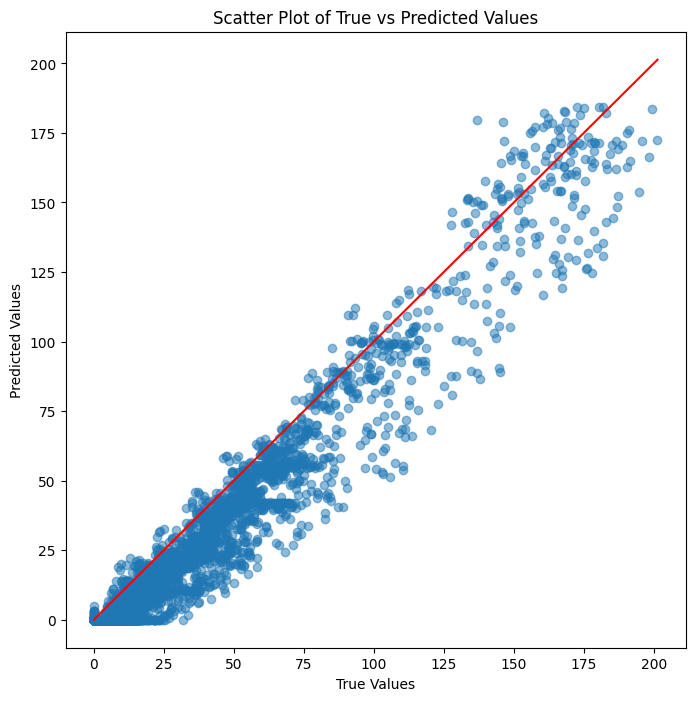

Root Mean Squared Error on Test Data: 16.846115
Mean Bias Error on Test Data: -0.4989353
Mean Absolute Error on Test Data: 9.747316
Kling-Gupta efficiency on Test Data: 0.7436235566439469
R2 Score on Test Data: 0.8087004264946105


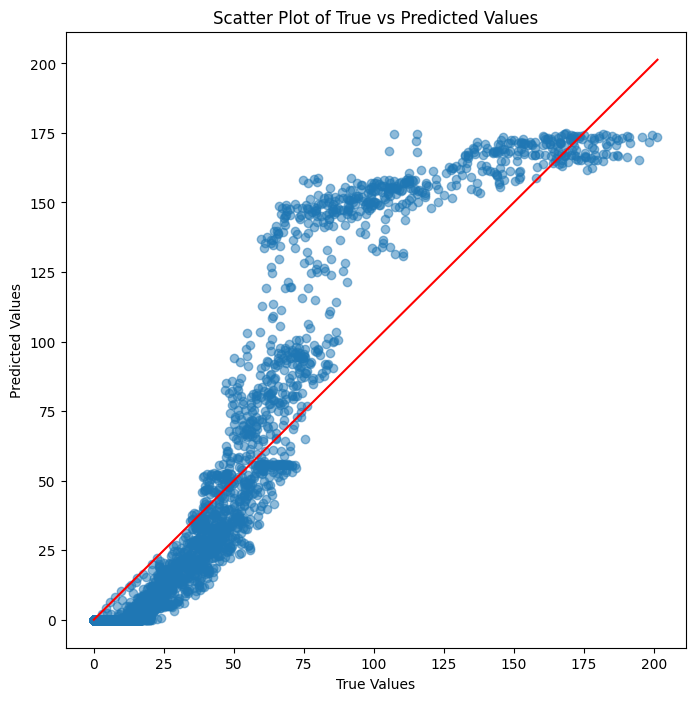

Root Mean Squared Error on Test Data: 68.899994
Mean Bias Error on Test Data: 26.93204
Mean Absolute Error on Test Data: 56.02487
Kling-Gupta efficiency on Test Data: -0.5606393272891443
R2 Score on Test Data: -2.3710403935623527


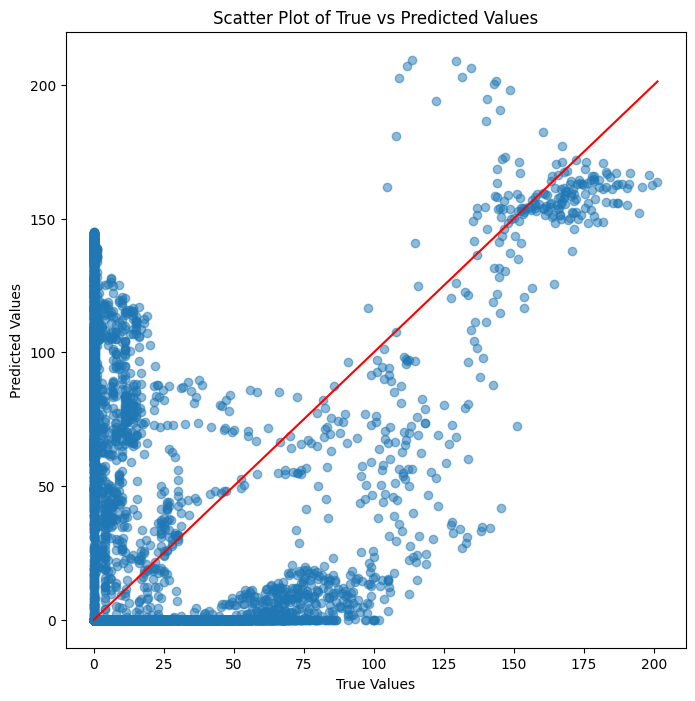

Root Mean Squared Error on Test Data: 12.556862
Mean Bias Error on Test Data: -4.616941
Mean Absolute Error on Test Data: 5.782108
Kling-Gupta efficiency on Test Data: 0.7412021505465775
R2 Score on Test Data: 0.8939908435237062


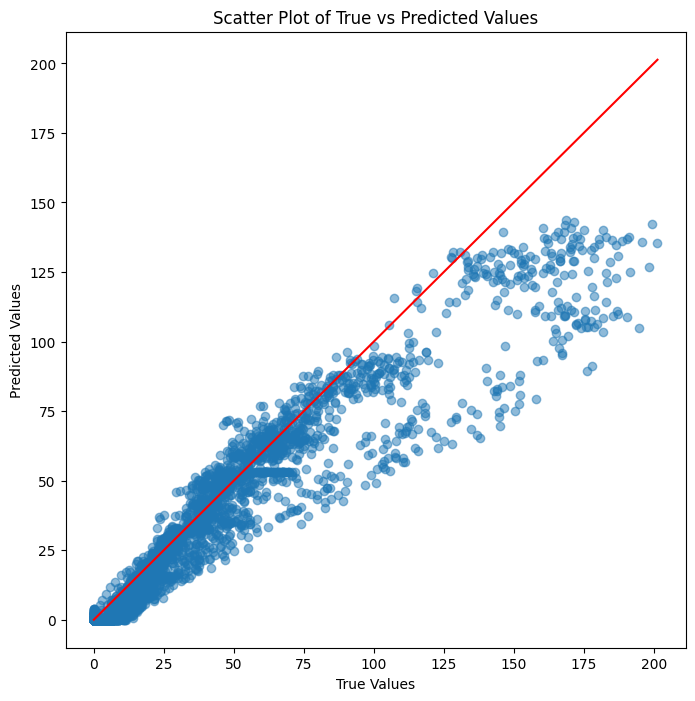

Root Mean Squared Error on Test Data: 14.383344
Mean Bias Error on Test Data: -6.413538
Mean Absolute Error on Test Data: 8.800911
Kling-Gupta efficiency on Test Data: 0.6168505705039893
R2 Score on Test Data: 0.8602852711805152


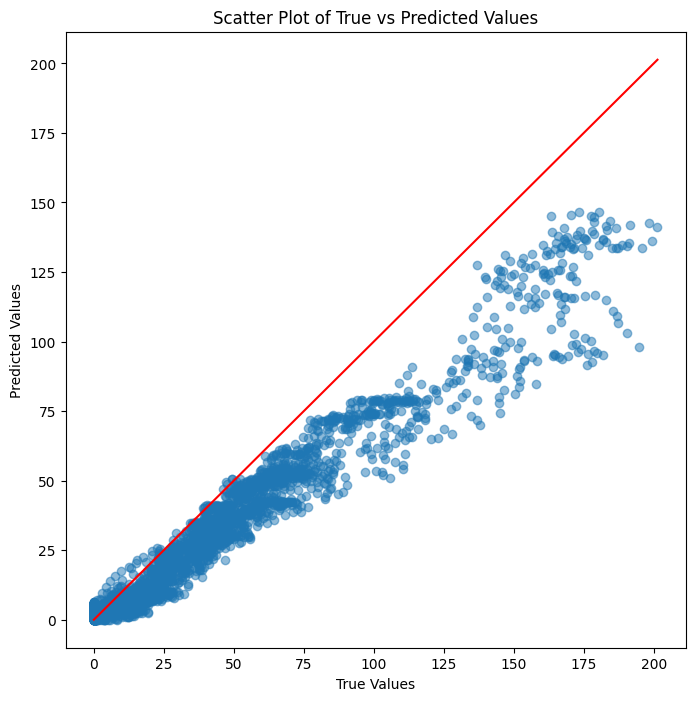

In [33]:
y_true, avg_prediction = average_prediction(MLSTM_sc.snowclass_models, df=df, df_test=df_test)

In [34]:
rmse_test = np.sqrt(mean_squared_error(y_true, avg_prediction))
kge_test = tool.kge(y_true.reshape(-1), avg_prediction.reshape(-1))
mae_test = mean_absolute_error(y_true, avg_prediction)
r2_test = r2_score(y_true, avg_prediction)
mbe_test = tool.mean_bias_error(y_true, avg_prediction) 

print('Root Mean Squared Error on Test Data:', rmse_test)
print('Mean Bias Error on Test Data:', mbe_test)
print('Mean Absolute Error on Test Data:', mae_test)
print('Kling-Gupta efficiency on Test Data:', kge_test)
print('R2 Score on Test Data:', r2_test)

Root Mean Squared Error on Test Data: 20.090027
Mean Bias Error on Test Data: 0.74701524
Mean Absolute Error on Test Data: 14.804812
Kling-Gupta efficiency on Test Data: 0.6730126731888884
R2 Score on Test Data: 0.7290296005457235
